In [15]:
# External Libaries required for the majority of the assignment, more to be added as more tasks are completed 
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

# Preprocessing
In this section, I will load the data, format it and interpret it's contents using a combination of graphs, and simple statistical measurements
### Loading the data

In [16]:
# IHDP Dataset
data = np.load('ihdp.npz')
# Jobs Dataset
data2 = np.load('jobs.npz')

### Data contents and formatting

In [17]:
# Column headers for data
# x --> Background Variables
# t --> Treatment Variable (Support or no support)
# yf --> Outcome Variable (Factual)
# ycf --> Outcome Variable (Counterfactual)
# ite --> individual treatment effect
for f in data.files:
  print(f'{f}: {data[f].shape}')

x: (747, 25)
t: (747, 1)
yf: (747, 1)
ycf: (747, 1)
ite: (747, 1)


In [18]:
# Column headers for data2
# x --> Background Variables
# t --> Treatment Variable (Training or no training)
# y --> Outcome Variable (Factual)
# e --> experimental or observational data
for f in data2.files:
  print(f'{f}: {data2[f].shape}')

x: (3212, 17)
t: (3212, 1)
y: (3212, 1)
e: (3212, 1)


In [19]:
IHDP_x = data['x']
IHDP_t = data['t']
IHDP_yf = data['yf']
IHDP_ycf = data['ycf']
IHDP_ite = data['ite']
# Average treatment effect of the IHDP dataset
print(np.mean(IHDP_ite))
Jobs_x = data2['x']
Jobs_t = data2['t']
Jobs_y = data2['y']
Jobs_e = data2['e']
limit=150

4.016066896118338


### Data exploration 
In this section, I convert our data to dataframe format and check for: Missing values, Non-numerical data, and any potential outliers

In [20]:
df_X = pd.DataFrame(IHDP_x)
df_t = pd.DataFrame(IHDP_t)
df_yf = pd.DataFrame(IHDP_yf)
df_ycf = pd.DataFrame(IHDP_ycf)
df_ite = pd.DataFrame(IHDP_ite)
# Remove hash's one by one and inspect the contents of each part of the data
#df_X.info()
#df_t.info()
#df_yf.info()
#df_ycf.info()
#df_ite.info()

There appears to be no missing data or non-numerical values from the IHDP dataset therefore no preprocessing is needed in regards to encoding and filling Nan rows.

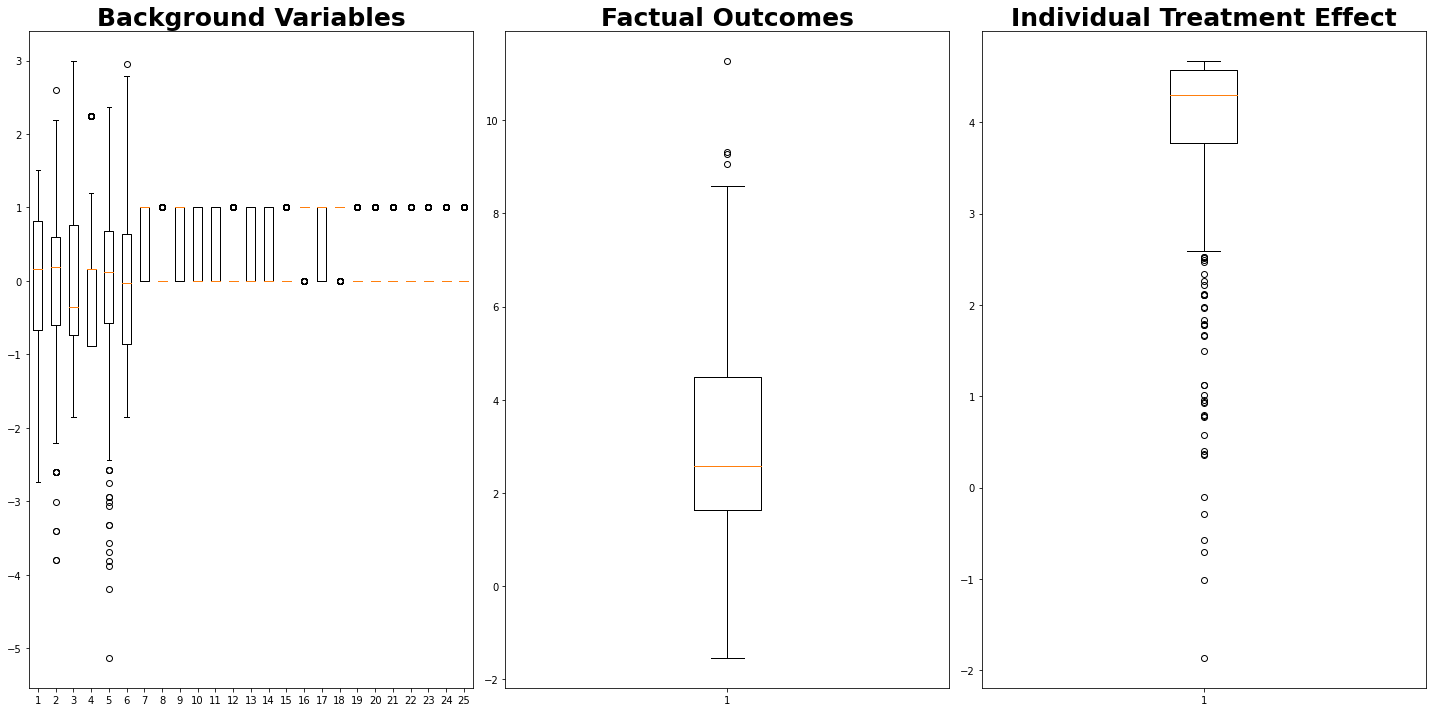

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20,10))
axs[0].boxplot(x = IHDP_x)
axs[0].set_title("Background Variables", fontsize=25, fontweight="bold")
axs[1].boxplot(x = IHDP_yf)
axs[1].set_title("Factual Outcomes", fontsize=25, fontweight="bold")
axs[2].boxplot(x = IHDP_ite)
axs[2].set_title("Individual Treatment Effect", fontsize=25, fontweight="bold")
plt.tight_layout()
#plt.savefig("BoxPlots.png", dpi=1200)

There does appear to be quite a few outliers in the IHDP dataset (as seen by the values lying outside the minimum and maximum of each box and whisker plot), especially in the non-binary variables. Given the spread of the data it may be best to standardize the data to prevent losing too much if we remove all the possible outliers however this can be experimented through different approaches to find what yields the more accurate results.

In [22]:
df_X = pd.DataFrame(Jobs_x)
df_t = pd.DataFrame(Jobs_t)
df_y = pd.DataFrame(Jobs_y)
df_e = pd.DataFrame(Jobs_e)
#df_X.info()
#df_t.info()
#df_y.info()
#df_e.info()

Similar to the IHDP dataset there appears to be no missing data or non-numerical values in jobs therefore no preprocessing is needed in regards to encoding and filling Nan rows.

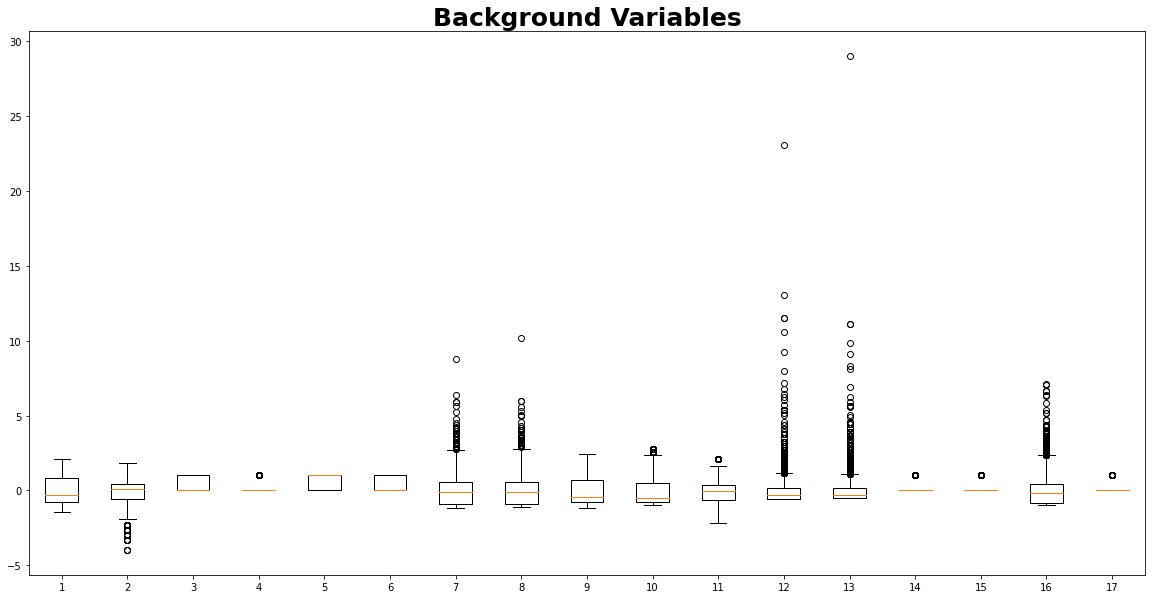

In [24]:
plt.figure(figsize=(20,10))
plt.boxplot(x = Jobs_x)
plt.title("Background Variables", fontsize=25, fontweight="bold")
#plt.savefig("BoxPlots2.png", dpi=1200)
plt.show()

Again, identical to IHDP, jobs contains a vast amount of outliers in the background variables, thus a similar approach of 
experimenting with standardization will need to be taken. This being said, we could also investigate random forest regression
models that should internally deal with any outliers and reduce the chance of our results being skewed or bias in any way

### Data Modelling 
In this section I will try and spot any patterns or obvious trends in the data plots, as well as any issues that may need to be preprocessed in order to work with the approach we are trying to take. 
#### IHDP Dataset

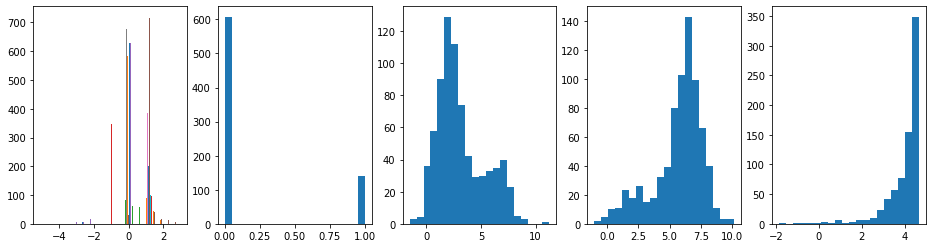

In [25]:
bins=20
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
axs[0].hist(IHDP_x, bins=bins)
axs[1].hist(IHDP_t, bins=bins)
axs[2].hist(IHDP_yf, bins=bins)
axs[3].hist(IHDP_ycf, bins=bins)
axs[4].hist(IHDP_ite, bins=bins)
#plt.savefig("Histo.png", dpi=1200)
plt.show()

The background variables X, although unbalanced, seem to demonstrate a typical shape given the dataset size, the same goes for both the factual and counter factual outcomes. The treatment variable is clearly represented as a binary, 0 being no treatment and 1 being treatment given. The individual treatment effect seems to be extremely negatively skewed although most of the values are around 4 which seems correct given our average treatment effect of 4.02

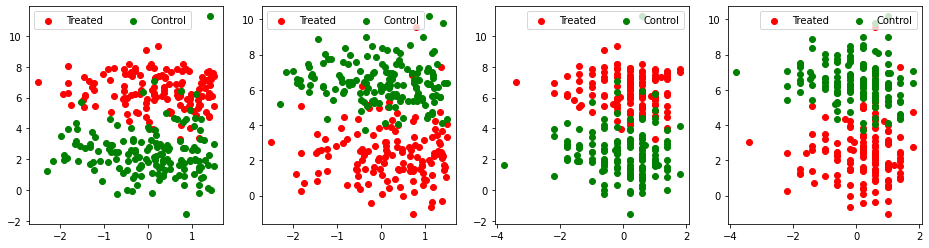

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# These scatterplots have only been made via factual outcomes 
# More scatterplots could be made to model the counterfactual outcomes

axs[0].scatter(IHDP_x[:, 0].reshape(-1, 1)[IHDP_t == 1][:limit], IHDP_yf[IHDP_t == 1][:limit], c = "r", label = "Treated")
axs[0].scatter(IHDP_x[:, 0].reshape(-1, 1)[IHDP_t == 0][:limit], IHDP_yf[IHDP_t == 0][:limit], c = "g", label = "Control")

axs[1].scatter(IHDP_x[:, 0].reshape(-1, 1)[IHDP_t == 1][:limit], IHDP_ycf[IHDP_t == 1][:limit], c = "r", label = "Treated")
axs[1].scatter(IHDP_x[:, 0].reshape(-1, 1)[IHDP_t == 0][:limit], IHDP_ycf[IHDP_t == 0][:limit], c = "g", label = "Control")

axs[2].scatter(IHDP_x[:, 1].reshape(-1, 1)[IHDP_t == 1][:limit], IHDP_yf[IHDP_t == 1][:limit], c = "r", label = "Treated")
axs[2].scatter(IHDP_x[:, 1].reshape(-1, 1)[IHDP_t == 0][:limit], IHDP_yf[IHDP_t == 0][:limit], c = "g", label = "Control")

axs[3].scatter(IHDP_x[:, 1].reshape(-1, 1)[IHDP_t == 1][:limit], IHDP_ycf[IHDP_t == 1][:limit], c = "r", label = "Treated")
axs[3].scatter(IHDP_x[:, 1].reshape(-1, 1)[IHDP_t == 0][:limit], IHDP_ycf[IHDP_t == 0][:limit], c = "g", label = "Control")

axs[0].legend(ncol=2)
axs[1].legend(ncol=2)
axs[2].legend(ncol=2)
axs[3].legend(ncol=2)
#plt.savefig("Scatter.png", dpi=1200)
plt.show()

Looking at the above graphs of the first two background variables (factual and counterfactual) measured against their outcomes with both the treated and control groups, we can observe some clear effects of the treatment which hopefully means they can be measured as we train and test our regression models.

#### Jobs Dataset

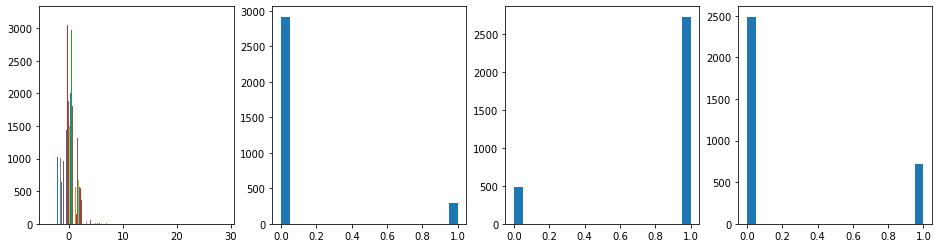

In [27]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].hist(Jobs_x, bins=bins)
axs[1].hist(Jobs_t, bins=bins)
# Treatement is Binary (Trained / Untrained)
axs[2].hist(Jobs_y, bins=bins)
# Outcome is binary (Employed / Unemployed)
axs[3].hist(Jobs_e, bins=bins)
# Sample contents is binary (Experimental / Observational)
plt.savefig("Histo2.png", dpi=1200)
plt.show()

Similarly to IHDP, the background variables in Jobs seem to be relatively unbalanced, however again demonstrate the typical shape for the relative dataset size. All of t, y, and e represent binary values of either 0 and 1 with all graphs being unbalanced in their distributions. What I mean by this is there is alot more of one result then there is the other (More 1's than 0's or vice verca)


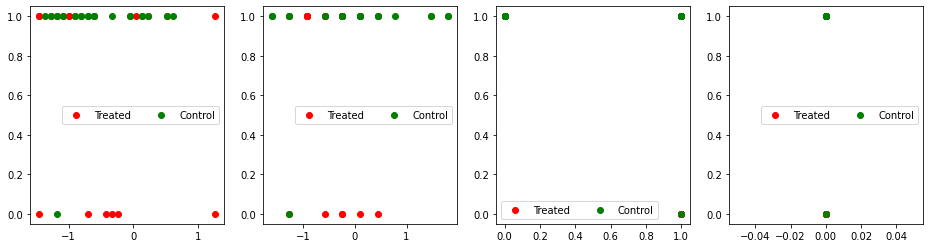

In [30]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
limit = 20
axs[0].scatter(Jobs_x[:, 0].reshape(-1, 1)[Jobs_t == 1][:limit], Jobs_y[Jobs_t == 1][:limit], c = "r", label = "Treated")
axs[0].scatter(Jobs_x[:, 0].reshape(-1, 1)[Jobs_t == 0][:limit], Jobs_y[Jobs_t == 0][:limit], c = "g", label = "Control")

axs[1].scatter(Jobs_x[:, 1].reshape(-1, 1)[Jobs_t == 1][:limit], Jobs_y[Jobs_t == 1][:limit], c = "r", label = "Treated")
axs[1].scatter(Jobs_x[:, 1].reshape(-1, 1)[Jobs_t == 0][:limit], Jobs_y[Jobs_t == 0][:limit], c = "g", label = "Control")

axs[2].scatter(Jobs_x[:, 2].reshape(-1, 1)[Jobs_t == 1][:limit], Jobs_y[Jobs_t == 1][:limit], c = "r", label = "Treated")
axs[2].scatter(Jobs_x[:, 2].reshape(-1, 1)[Jobs_t == 0][:limit], Jobs_y[Jobs_t == 0][:limit], c = "g", label = "Control")

axs[3].scatter(Jobs_x[:, 3].reshape(-1, 1)[Jobs_t == 1][:limit], Jobs_y[Jobs_t == 1][:limit], c = "r", label = "Treated")
axs[3].scatter(Jobs_x[:, 3].reshape(-1, 1)[Jobs_t == 0][:limit], Jobs_y[Jobs_t == 0][:limit], c = "g", label = "Control")

axs[0].legend(ncol=2)
axs[1].legend(ncol=2)
axs[2].legend(ncol=2)
axs[3].legend(ncol=2)
#plt.savefig("Scatter2.png", dpi=1200)
plt.show()

As opposed to IHDP jobs outcomes is recorded as a binary variables thus only plotting scatter points on 0 and 1. It is significantly harder to spot obvious effects given the 4 graphs above, however this could just be a coincidence given the background variables we have chosen to plot. 

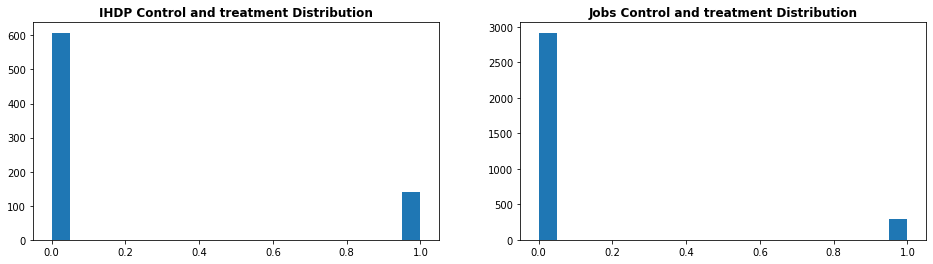

In [32]:
bins=20
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].hist(IHDP_t, bins=bins)
axs[0].set_title("IHDP Control and treatment Distribution", fontsize=12, fontweight="bold")
axs[1].hist(Jobs_t, bins=bins)
axs[1].set_title("Jobs Control and treatment Distribution", fontsize=12, fontweight="bold")
#plt.savefig("CTsplit.png", dpi=1200)
plt.show()

The above graphs confirm our need to use X-learner. There is clear inbalance towards the treatment and control groups in both datasets, hopefully X-learner should be able to deal with this when calculating our CATE value. 

### Splitting and Standardizing the datasets
I'm looking here to split the datasets with the same ratios of 80/20, and then create a function that given the parameters that are used to call it, return standardized data. 

In [33]:
IHDP_x_train, IHDP_x_test, IHDP_t_train, IHDP_t_test, IHDP_yf_train, IHDP_yf_test, IHDP_ite_train, IHDP_ite_test = train_test_split(IHDP_x, IHDP_t, IHDP_yf, IHDP_ite, test_size=0.2)
Jobs_x_train, Jobs_x_test, Jobs_t_train, Jobs_t_test, Jobs_y_train, Jobs_y_test = train_test_split(Jobs_x, Jobs_t, Jobs_y, test_size=0.2)

In [34]:
def standardize(scale_x, scale_y, x=None, y=None):
    scaler = StandardScaler()
    if scale_x == True:
        return scaler.fit_transform(x)
    elif scale_y == True:
        return scaler.fit_transform(y)

This function returns the standardized versions of the data provided to it.

# Training our models